In [8]:
from ai2thor.controller import Controller

def print_objects(prop):
    print(f"Printing: {prop}")
    for obj in controller.last_event.metadata["objects"]:
        if obj['visible'] and obj[prop]:
            print(obj['objectId'])

In [269]:
#controller = Controller(renderDepthImage=True, renderInstanceSegmentation=True)
#events = [controller.last_event]
#
#while True:
#    next_action = input()
#    if next_action == "Done":
#        controller.stop()
#        break
#    elif next_action == "printVis":
#        print_objects("pickupable")
#        continue
#    
#    if next_action == "PickupObject":
#        print_objects("pickupable")
#        obj_id = input()
#        event = controller.step(action=next_action, objectId=obj_id)
#    elif next_action == "PutObject":
#        print_objects("receptacle")
#        obj_id = input()
#        event = controller.step(action=next_action, objectId=obj_id)
#    else:
#        event = controller.step(action=next_action)
#    events.append(event)

In [270]:
#import pickle
#
#with open('events_trial.pkl', 'wb') as f:
#    pickle.dump(events, f)

In [146]:
def getObjectById(event, object_id):
    for obj in event.metadata["objects"]:
        if obj["objectId"] == object_id:
            return obj
    return None

In [271]:
from transformers import ViTModel, ViTFeatureExtractor
import pickle


with open('events_trial.pkl', 'rb') as f:
    events = pickle.load(f)


model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

observations = []
for i in range(len(events)-1):
    prev_action_event = events[i]
    action_event = events[i+1]
    observation = {
        "action": action_event.metadata["lastAction"]
    }
    if observation["action"] == "PickupObject":
        observation["objectId"] = action_event.metadata["actionReturn"]
        obj = getObjectById(prev_action_event, observation["objectId"])
        objPos = obj['position']
        observation["objectPos"] = torch.tensor([objPos['x'], objPos['y'], objPos['z']])
        observation["objectCrop"] = torch.from_numpy(action_event.frame.copy())[150:250, 100:200].permute(2, 0, 1)
        
        objectFeatures = feature_extractor(images=observation["objectCrop"], return_tensors="pt")
        observation["objectEmb"] = model(**objectFeatures).pooler_output.squeeze()
        
        receptacleId = obj['parentReceptacles'][0]
        observation["receptacleId"] = receptacleId
        receptacle = getObjectById(event, receptacleId)
        receptaclePos = receptacle['position']
        observation["receptaclePos"] = torch.tensor([receptaclePos['x'], receptaclePos['y'], receptaclePos['z']])
        
        x1, y1, x2, y2 = prev_action_event.instance_detections2D[receptacleId]
        observation["receptacleCrop"] = torch.from_numpy(prev_action_event.frame.copy())[y1:y2, x1:x2].permute(2, 0, 1)
        receptacleFeatures = feature_extractor(images=observation["receptacleCrop"], return_tensors="pt")
        observation["receptacleEmb"] = model(**receptacleFeatures).pooler_output.squeeze()
    else:
        continue
    observations.append(observation)

In [272]:
import torch.nn.functional as F


class GraphNode:
    def __init__(self, pos, emb, ai2thorid):
        self.pos = pos
        self.emb = emb
        self.children_ids = []
        self.ai2thorid = ai2thorid.split('|')[0]
        
        self.pos_thr = 0.99
        self.emb_thr = 0.9

    def isEqual(self, pos, emb):
        return F.cosine_similarity(self.emb, emb, dim=0) > self.emb_thr and F.cosine_similarity(self.pos, pos, dim=0) > self.pos_thr

    def addChild(self, child_id):
        self.children_ids.append(child_id)


class Graph:
    def __init__(self):
        self.nodes = []
        
    def find(self, pos, emb):
        for node_id in range(len(self.nodes)):
            if self.nodes[node_id].isEqual(pos, emb):
                node_id
        return -1
        
    def addNode(self, pos, emb, ai2thorid):
        new_node_id = len(self.nodes)
        self.nodes.append(GraphNode(pos, emb, ai2thorid))
        return new_node_id
    
    def addChildNode(self, parent_id, pos, emb, ai2thorid):
        new_child_id = self.addNode(pos, emb, ai2thorid)
        self.nodes[parent_id].addChild(new_child_id)
        
def build_graph(observations):
    g = Graph()
    
    for obs in observations:
        receptacle_id = g.find(pos=obs["receptaclePos"], emb=obs["receptacleEmb"])
        object_id = g.find(pos=obs["objectPos"], emb=obs["objectEmb"])
        if receptacle_id == -1:
            node_id = g.addNode(obs["receptaclePos"], obs["receptacleEmb"], ai2thorid=obs["receptacleId"])
            g.addChildNode(parent_id=node_id, pos=obs["objectPos"], emb=obs["objectEmb"], ai2thorid=obs["objectId"])
        elif object_id == -1:
            g.addChildNode(parent_id=receptacle_id, pos=obs["objectPos"], emb=obs["objectEmb"], ai2thorid=obs["objectId"])
    
    return g

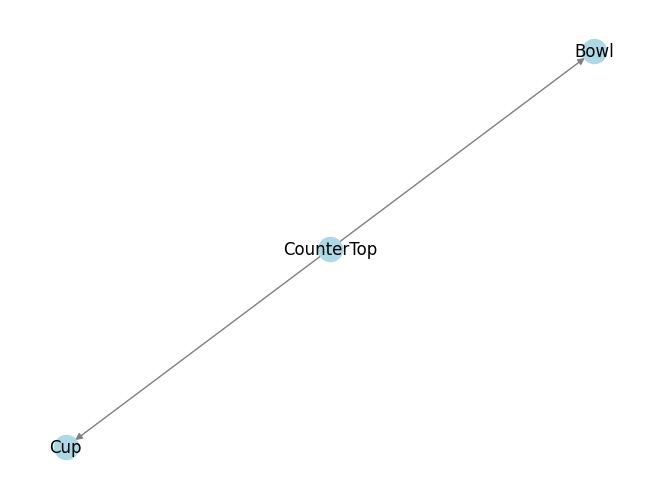

In [273]:
import networkx as nx
import matplotlib.pyplot as plt

g = build_graph(observations)

DG = nx.DiGraph()

for node in g.nodes:
    DG.add_node(node.ai2thorid)

for node in g.nodes:
    for child_node_id in node.children_ids:
        DG.add_edge(node.ai2thorid, g.nodes[child_node_id].ai2thorid)


nx.draw(DG, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()